# How to use decision trees to predict equity returns and price moves

In this notebook, we illustrate how to use tree-based models to gain insight and make predictions. 

To demonstrate regression trees we predict returns, and for the classification case, we return to the example of positive and negative asset price moves.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import os, sys
from pathlib import Path

import numpy as np
from scipy.stats import spearmanr
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, _tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, make_scorer
import graphviz

import statsmodels.api as sm

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [4]:
sns.set_style('white')

In [5]:
results_path = Path('results', 'decision_trees')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Load Model Data

We use a simplified version of the data set constructed in Chapter 4, Alpha factor research. It consists of daily stock prices provided by Quandl for the 2010-2017 period and various engineered features. The details can be found in the notebook [data_prep](00_data_prep.ipynb) in the GitHub repo for this chapter.

The decision tree models in this chapter are not equipped to handle missing or categorical variables, so we will apply dummy encoding to the latter after dropping any of the former.

In [6]:
with pd.HDFStore('data.h5') as store:
    data = store['us/equities/monthly']
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 78175 entries, ('A', Timestamp('2006-11-30 00:00:00')) to ('ZION', Timestamp('2017-11-30 00:00:00'))
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   atr            78175 non-null  float64
 1   bb_down        78175 non-null  float64
 2   bb_high        78175 non-null  float64
 3   bb_low         78175 non-null  float64
 4   bb_mid         78175 non-null  float64
 5   bb_up          78175 non-null  float64
 6   macd           78175 non-null  float64
 7   natr           78175 non-null  float64
 8   rsi            78175 non-null  float64
 9   sector         78175 non-null  object 
 10  return_1m      78175 non-null  float64
 11  return_3m      78175 non-null  float64
 12  return_6m      78175 non-null  float64
 13  return_12m     78175 non-null  float64
 14  beta           78175 non-null  float64
 15  SMB            78175 non-null  float64
 16  HML            7817

## Simple Regression Tree with Time Series Data

Regression trees make predictions based on the mean outcome value for the training samples assigned to a given node and typically rely on the mean-squared error to select optimal rules during recursive binary splitting.

Given a training set, the algorithm iterates over the predictors, $X_1, X_2, ..., X_p$, and possible cutpoints, $s_1, s_2, ..., s_N$, to find an optimal combination. The optimal rule splits the feature space into two regions, $\{X\mid X_i < s_j\}$ and $\{X\mid X_i > s_j\}$, with values for the $X_i$ feature either below or above the $s_j$ threshold so that predictions based on the training subsets maximize the reduction of the squared residuals relative to the current node.

### Generate two lags of monthly returns

In [7]:
X2 = data.loc[:, ['target', 'return_1m']]
X2.columns = ['y', 't-1']
X2['t-2'] = data.groupby(level='ticker').return_1m.shift()
X2 = X2.dropna()
X2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 77564 entries, ('A', Timestamp('2006-12-31 00:00:00')) to ('ZION', Timestamp('2017-11-30 00:00:00'))
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       77564 non-null  float64
 1   t-1     77564 non-null  float64
 2   t-2     77564 non-null  float64
dtypes: float64(3)
memory usage: 2.2+ MB


In [8]:
y2 = X2.y
X2 = X2.drop('y', axis=1)

### Explore Data

Note the small spike where we clipped the data.

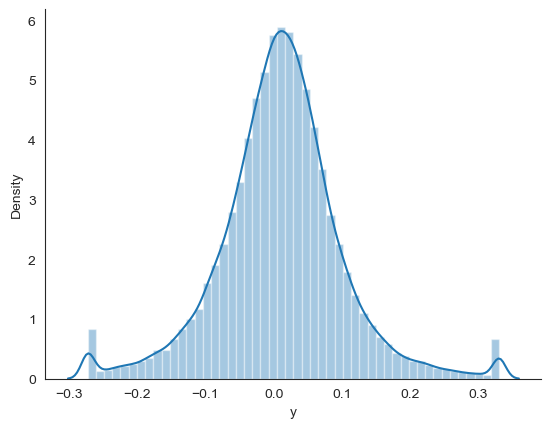

In [9]:
sns.distplot(y2)
sns.despine();

### Configure Tree

Let's start with a simplified example to facilitate visualization and only use two months of lagged returns to predict the following month, in the vein of an AR(2) model from the last chapter:

In [10]:
reg_tree_t2 = DecisionTreeRegressor(criterion='squared_error',
                                    splitter='best',
                                    max_depth=6,
                                    min_samples_split=2,
                                    min_samples_leaf=50,
                                    min_weight_fraction_leaf=0.0,
                                    max_features=None,
                                    random_state=42,
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0)

### Train Decision Tree

In [11]:
%%timeit
reg_tree_t2.fit(X=X2, y=y2)

102 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
reg_tree_t2.fit(X=X2, y=y2)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=50, random_state=42)

### Visualize Tree

You can visualize the tree using the graphviz library (see GitHub for installation instructions) because sklearn can output a description of the tree using the .dot language used by that library. 

You can configure the output to include feature and class labels and limit the number of levels to keep the chart readable, as follows:

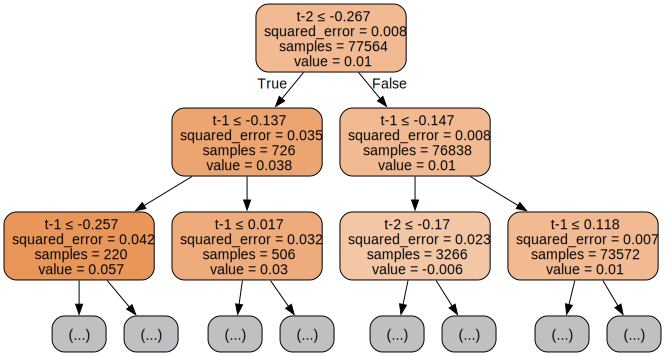

In [13]:
out_file = results_path / 'reg_tree_t2.dot'
dot_data = export_graphviz(reg_tree_t2,
                          out_file=out_file.as_posix(),
                          feature_names=X2.columns,
                          max_depth=2,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Compare with Linear Regression

The OLS summary below and a visualization of the first two levels of the decision tree above reveal the striking differences between the models. The OLS model provides three parameters for the intercepts and the two features in line with the linear assumption.

In contrast, the regression tree chart above displays for each node of the first two levels the feature and threshold used to split the data (note that features can be used repeatedly), as well as the current value of the mean-squared error (MSE), the number of samples, and predicted value based on these training samples.

The tree chart also highlights the uneven distribution of samples across the nodes as the numbers vary between 31,000 and 65,000 samples after only two splits.

#### statsmodels OLS

In [14]:
ols_model = sm.OLS(endog=y2, exog=sm.add_constant(X2))

In [15]:
%%timeit
ols_model.fit()

61.3 µs ± 495 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [16]:
result = ols_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     31.35
Date:                Tue, 28 May 2024   Prob (F-statistic):           2.46e-14
Time:                        01:27:36   Log-Likelihood:                 76144.
No. Observations:               77564   AIC:                        -1.523e+05
Df Residuals:                   77561   BIC:                        -1.523e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0099      0.000     30.099      0.0

#### sklearn Linear Regression

In [17]:
lin_reg = LinearRegression()

In [18]:
%%timeit
lin_reg.fit(X=X2,y=y2)

1.99 ms ± 79.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
lin_reg.fit(X=X2,y=y2)

LinearRegression()

In [20]:
lin_reg.intercept_

0.00991171308496968

In [21]:
lin_reg.coef_

array([ 0.02246377, -0.01777989])

### Linear Regression vs Regression Tree Decision Surfaces

To further illustrate the different assumptions about the functional form of the relationships between the input variables and the output, we can visualize current return predictions as a function of the feature space, that is, as a function of the range of values for the lagged returns. The following figure shows the current period return as a function of returns one and two periods ago for linear regression and the regression tree:

The linear-regression model result on the right side underlines the linearity of the relationship between lagged and current returns, whereas the regression tree chart on the left illustrates the non-linear relationship encoded in the recursive partitioning of the feature space.

In [22]:
t1, t2 = np.meshgrid(np.linspace(X2['t-1'].quantile(.01), X2['t-1'].quantile(.99), 100),
                     np.linspace(X2['t-2'].quantile(.01), X2['t-2'].quantile(.99), 100))
X_data = np.c_[t1.ravel(), t2.ravel()]

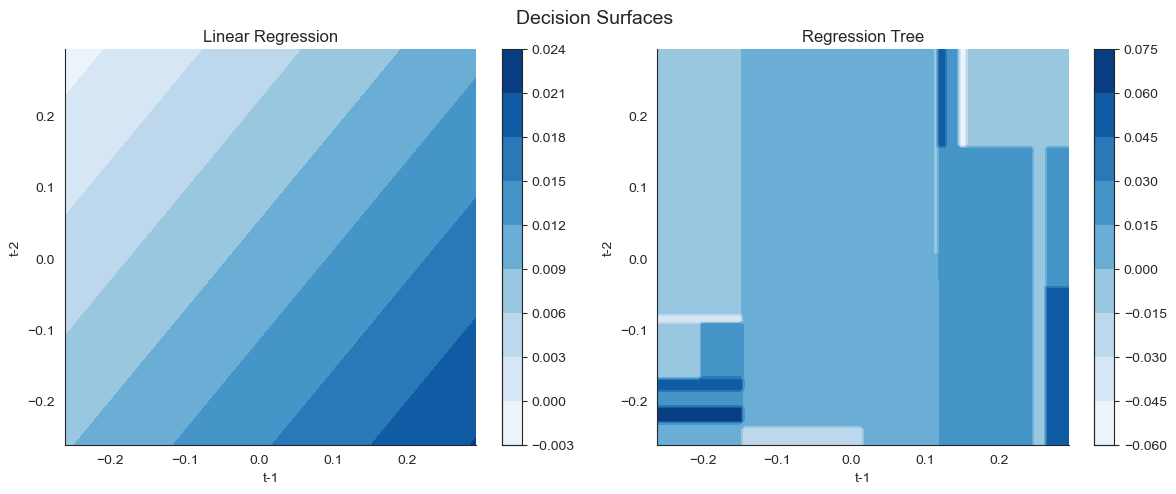

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
ret1 = lin_reg.predict(X_data).reshape(t1.shape)
surface1 = axes[0].contourf(t1, t2, ret1, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
ret2 = reg_tree_t2.predict(X_data).reshape(t1.shape)
surface2 = axes[1].contourf(t1, t2, ret2, cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Linear Regression', 'Regression Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('t-1')
    ax.set_ylabel('t-2')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);

## Simple Classification Tree with Time Series Data

A classification tree works just like the regression version, except that categorical nature of the outcome requires a different approach to making predictions and measuring the loss. While a regression tree predicts the response for an observation assigned to a leaf node using the mean outcome of the associated training samples, a classification tree instead uses the mode, that is, the most common class among the training samples in the relevant region. A classification tree can also generate probabilistic predictions based on relative class frequencies.

### Loss Functions

When growing a classification tree, we also use recursive binary splitting but, instead of evaluating the quality of a decision rule using the reduction of the mean-squared error, we can use the classification error rate, which is simply the fraction of the training samples in a given (leave) node that do not belong to the most common class.

However, the alternative measures, Gini Index or Cross-Entropy, are preferred because they are more sensitive to node purity than the classification error rate. Node purity refers to the extent of the preponderance of a single class in a node. A node that only contains samples with outcomes belonging to a single class is pure and imply successful classification for this particular region of the feature space. 

In [24]:
def entropy(f):
    return (-f*np.log2(f) - (1-f)*np.log2(1-f))/2

In [25]:
def gini(f):
    return 2*f*(1-f)

In [26]:
def misclassification_rate(f):
    return np.where(f<=.5, f, 1-f)

Both the Gini Impurity and the Cross-Entropy measure take on smaller values when the class proportions approach zero or one, that is, when the child nodes become pure as a result of the split and are highest when the class proportions are even or 0.5 in the binary case. 

The chart below visualizes the values assumed by these two measures and the misclassification error rates across the [0, 1] interval of proportions.

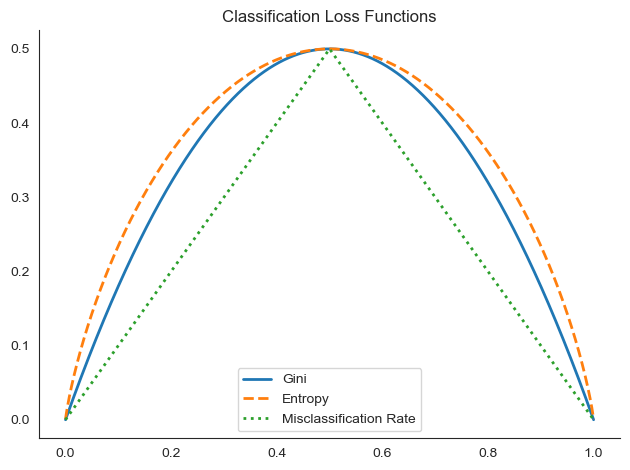

In [27]:
x = np.linspace(0, 1, 10000)
(pd.DataFrame({'Gini': gini(x), 
              'Entropy': entropy(x),
             'Misclassification Rate': misclassification_rate(x)}, index=x)
 .plot(title='Classification Loss Functions', lw=2, style=['-', '--', ':']))
sns.despine()
plt.tight_layout();

#### Compare computation time

Gini is often preferred over entropy because it computes faster:

In [28]:
%%timeit
misclassification_rate(x)

10.5 µs ± 296 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [29]:
%%timeit
gini(x)

9.13 µs ± 266 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [30]:
%%timeit
entropy(x)

88 µs ± 1.24 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Configure Tree

In [31]:
clf_tree_t2 = DecisionTreeClassifier(criterion='gini',
                                     splitter='best',
                                     max_depth=5,
                                     min_samples_split=1000,
                                     min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0,
                                     max_features=None,
                                     random_state=42,
                                     max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     class_weight=None)

### Train Tree

In [32]:
y_binary = (y2>0).astype(int)
y_binary.value_counts()

y
1    43608
0    33956
Name: count, dtype: int64

In [33]:
%%timeit
clf_tree_t2.fit(X=X2, y=y_binary)

87.8 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
clf_tree_t2.fit(X=X2, y=y_binary)

DecisionTreeClassifier(max_depth=5, min_samples_split=1000, random_state=42)

### Visualize Tree

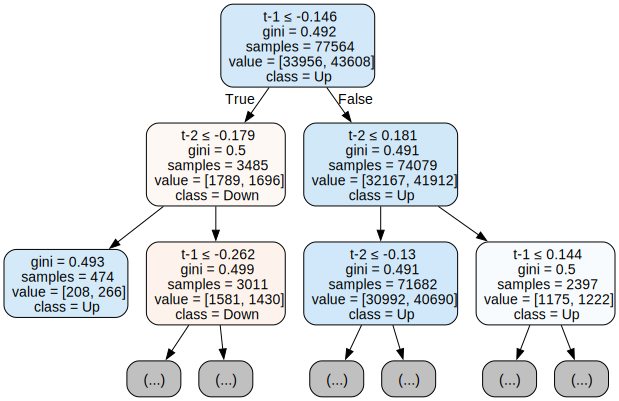

In [35]:
out_file = results_path / 'clf_tree_t2.dot'
dot_data = export_graphviz(clf_tree_t2,
                           out_file=out_file.as_posix(),
                           feature_names=X2.columns,
                           class_names=['Down', 'Up'],
                           max_depth=2,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Compare with Logistic Regression

#### Statsmodels

In [36]:
log_reg_sm = sm.Logit(endog=y_binary, exog=sm.add_constant(X2))

In [37]:
%%timeit
log_reg_sm.fit(disp=False)

12.4 ms ± 308 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
log_result = log_reg_sm.fit()

Optimization terminated successfully.
         Current function value: 0.685307
         Iterations 4


In [39]:
print(log_result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                77564
Model:                          Logit   Df Residuals:                    77561
Method:                           MLE   Df Model:                            2
Date:                Tue, 28 May 2024   Pseudo R-squ.:               0.0001131
Time:                        01:28:19   Log-Likelihood:                -53155.
converged:                       True   LL-Null:                       -53161.
Covariance Type:            nonrobust   LLR p-value:                  0.002451
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2480      0.007     33.882      0.000       0.234       0.262
t-1            0.2727      0.080      3.421      0.001       0.116       0.429
t-2           -0.0504      0.080     -0.633      0.5

#### sklearn

In [40]:
log_reg_sk = LogisticRegression()

In [41]:
%%timeit
log_reg_sk.fit(X=X2, y=y_binary)

23.5 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
log_reg_sk.fit(X=X2, y=y_binary)

LogisticRegression()

In [43]:
log_reg_sk.coef_

array([[ 0.27097512, -0.04999822]])

### Decision Surfaces: Classifier Tree vs. Logistic Regression 

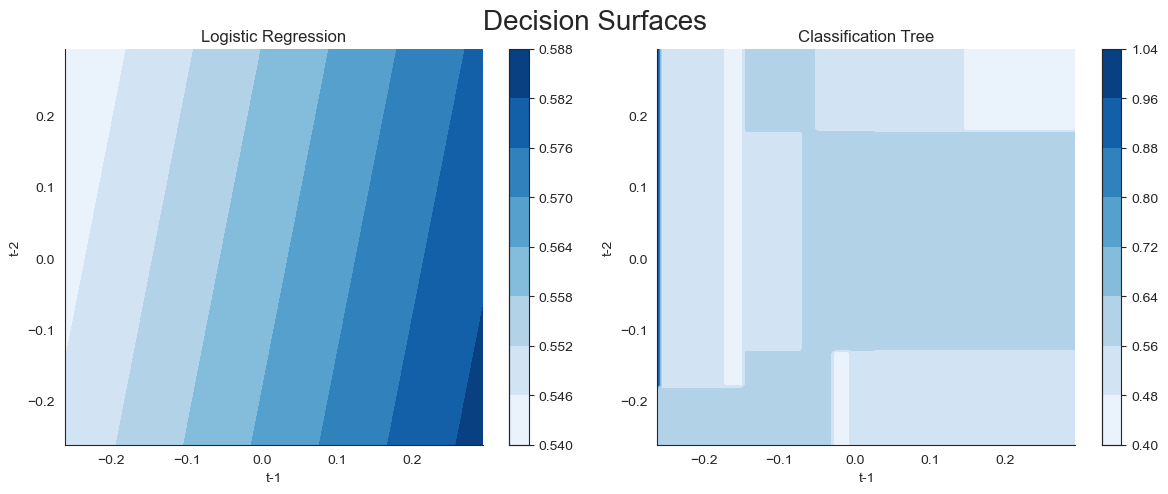

In [44]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
ret1 = log_reg_sk.predict_proba(X_data)[:, 1].reshape(t1.shape)
surface1 = axes[0].contourf(t1, t2, ret1, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
ret2 = clf_tree_t2.predict_proba(X_data)[:, 1].reshape(t1.shape)
surface2 = axes[1].contourf(t1, t2, ret2, cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Logistic Regression', 'Classification Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('t-1')
    ax.set_ylabel('t-2')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=20)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);

## Regression Tree with all Features

We now train, visualize, and evaluate a regression tree with up to 5 consecutive splits using 80% of the samples for training to predict the remaining 20%.

We are taking a shortcut here to simplify the illustration and use the built-in train_test_split, which does not protect against lookahead bias, as our custom iterator. The tree configuration implies up to $2^5=32$ leaf nodes that, on average in the balanced case, would contain over 4,300 of the training samples.

### Train-Test Split

In [45]:
X = pd.get_dummies(data.drop('target', axis=1))
y = data.target

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Configure Tree

The output after training the model displays all the DecisionTreeClassifier parameters that we will address in more detail in the next section when we discuss parameter-tuning. 

In [47]:
regression_tree = DecisionTreeRegressor(criterion='squared_error',
                                        splitter='best',
                                        max_depth=5,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None,
                                        random_state=42,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0)

### Train Model

In [48]:
regression_tree.fit(X=X_train, y=y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

### Visualize Tree

The result shows that the model uses a variety of different features and indicates the split rules for both continuous and categorical (dummy) variables. 

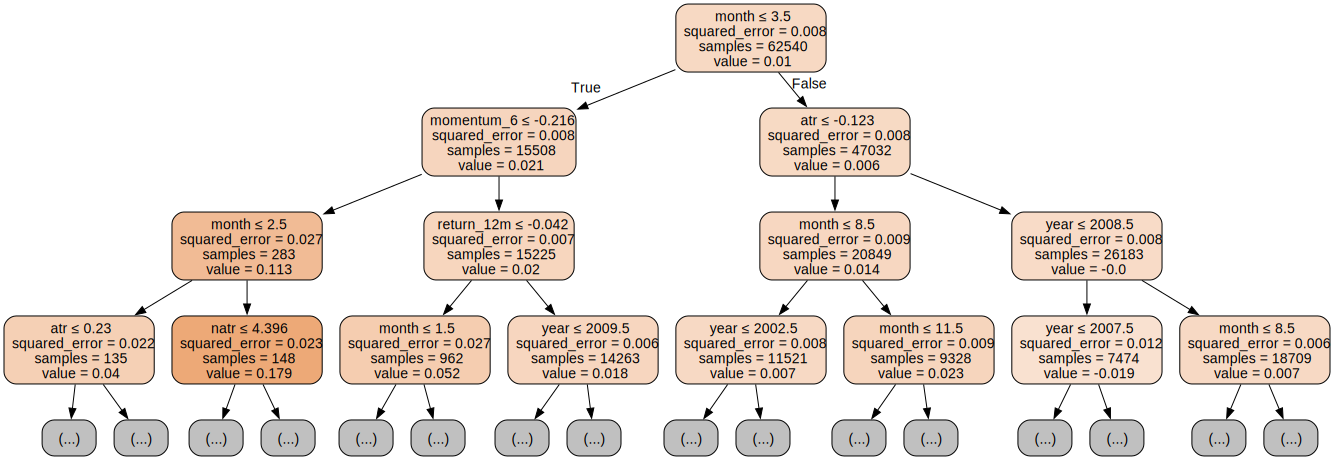

In [49]:
out_file = results_path / 'reg_tree.dot'
dot_data = export_graphviz(regression_tree,
                           out_file=out_file.as_posix(),
                           feature_names=X_train.columns,
                           max_depth=3,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Evaluate Test Set

In [50]:
y_pred = regression_tree.predict(X_test)

In [51]:
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))

0.08705921563250489

In [52]:
r, p = spearmanr(y_pred, y_test)
print(f'{r*100:.2f} (p-value={p:.2%})')

19.71 (p-value=0.00%)


## Classification Tree with all Features

We will now train, visualize, and evaluate a classification tree with up to 5 consecutive splits using 80% of the samples for training to predict the remaining 20%. We are taking a shortcut here to simplify the illustration and use the built-in train_test_split, which does not protect against lookahead bias, as our custom iterator. The tree configuration implies up to $2^5=32$ leaf nodes that, on average in the balanced case, would contain over 4,300 of the training samples.

### Train-Test Split

In [53]:
y_binary = (y>0).astype(int)
y_binary.value_counts()

target
1    43931
0    34244
Name: count, dtype: int64

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [55]:
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=5,
                             random_state=42)

In [56]:
clf.fit(X=X_train, y=y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

### Plot Tree

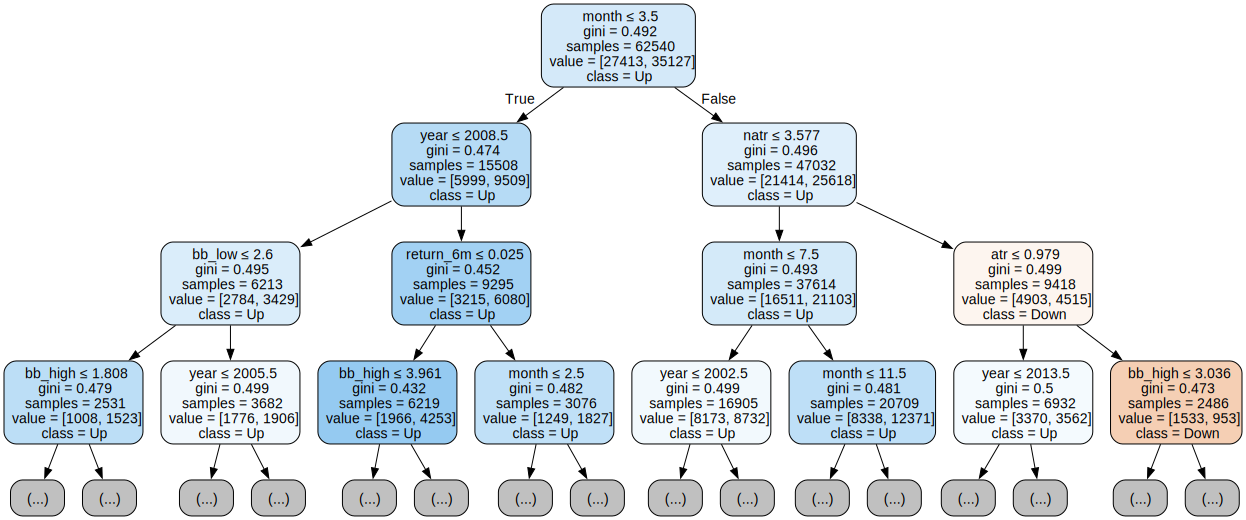

In [57]:
out_file = results_path / 'clf_tree.dot'
dot_data = export_graphviz(clf,
                           out_file=out_file.as_posix(),
                           feature_names=X.columns,
                           class_names=['Down', 'Up'],
                           max_depth=3,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Evaluate Test Set

To evaluate the predictive accuracy of our first classification tree, we will use our test set to generate predicted class probabilities. 

The `.predict_proba()` method produces one probability for each class. In the binary class, these probabilities are complementary and sum to 1, so we only need the value for the positive class. 

In [58]:
y_score = clf.predict_proba(X=X_test)[:, 1]

To evaluate the generalization error, we will use the area under the curve based on the receiver-operating characteristic that we introduced in Chapter 6, The Machine Learning Process. The result indicates a significant improvement above and beyond the baseline value of 0.5 for a random prediction:

In [59]:
roc_auc_score(y_score=y_score, y_true=y_test)

0.6054550037176512

### Print Decision Path

Inspired by https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree

In [60]:
from sklearn.tree._tree import Tree
help(Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child 

In [61]:
def tree_to_code(tree, feature_names):
    if isinstance(tree, DecisionTreeClassifier):
        model = 'clf'
    elif isinstance(tree, DecisionTreeRegressor):
        model = 'reg'
    else:
        raise ValueError('Need Regression or Classification Tree')
        
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(indent, f'if {name} <= {threshold:.2%}')
            recurse(tree_.children_left[node], depth + 1)
            print(indent, f'else:  # if {name} > {threshold:.2%}')
            recurse(tree_.children_right[node], depth + 1)
        else:
            pred = tree_.value[node][0]
            val = pred[1]/sum(pred) if model == 'clf' else pred[0]
            print(indent, f'return {val:.2%}')
    recurse(0, 1)

In [62]:
tree_to_code(clf_tree_t2, X2.columns)

def tree(t-1, t-2):
   if t-1 <= -14.64%
     if t-2 <= -17.93%
       return 56.12%
     else:  # if t-2 > -17.93%
       if t-1 <= -26.16%
         return 40.86%
       else:  # if t-1 > -26.16%
         if t-1 <= -26.14%
           return 100.00%
         else:  # if t-1 > -26.14%
           if t-1 <= -17.39%
             return 50.67%
           else:  # if t-1 > -17.39%
             return 46.62%
   else:  # if t-1 > -14.64%
     if t-2 <= 18.14%
       if t-2 <= -13.04%
         if t-1 <= -2.68%
           if t-2 <= -13.10%
             return 57.08%
           else:  # if t-2 > -13.10%
             return 12.50%
         else:  # if t-1 > -2.68%
           if t-1 <= -0.57%
             return 44.64%
           else:  # if t-1 > -0.57%
             return 52.15%
       else:  # if t-2 > -13.04%
         if t-1 <= -6.59%
           if t-1 <= -6.66%
             return 54.59%
           else:  # if t-1 > -6.66%
             return 41.67%
         else:  # if t-1 > -6.59%
          

## Overfitting, Regularization & Parameter Tuning

Decision trees have a strong tendency to overfit, especially when a dataset has a large number of features relative to the number of samples. As discussed in previous chapters, overfitting increases the prediction error because the model does not only learn the signal contained in the training data, but also the noise.
There are several ways to address the risk of overfitting.

Decision trees provide several regularization hyperparameters to limit the growth of a tree and the associated complexity. While every split increases the number of nodes, it also reduces the number of samples available per node to support a prediction. For each additional level, twice the number of samples is needed to populate the new nodes with the same sample density. 

### Decision Tree Parameters

The following table lists key parameters available for this purpose in the sklearn decision tree implementation. After introducing the most important parameters, we will illustrate how to use cross-validation to optimize the hyperparameter settings with respect to the bias-variance tradeoff and lower prediction errors:

| Parameter                | Default | Options                                                                                                                                                               | Description                                                                                                                                                                                                             |
|--------------------------|---------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| criterion                | gini    | Regression: MSE, MAE Classification: Gini impurity, Cross Entropy                                                                                                     | Metric to evaluate split quality.                                                                                                                                                                                       |
| splitter                 | best    | best, random                                                                                                                                                          | How to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.                                                                            |
| max_depth                | None    | int                                                                                                                                                                   | Max # of levels in tree. Split nodes until max_depth is reached or all leaves are pure or all leaves contain less than min_samples_split samples.                                                                       |
| max_features             | None    | None: max_features=n_features; int; float (fraction): int(max_features * n_features)  auto, sqrt: max_features=sqrt(n_features). log2: max_features=log2(n_features). | # of features to consider when evaluating split                                                                                                                                                                         |
| max_leaf_nodes           | None    | None: unlimited # of leaf nodes int                                                                                                                                   | Continue to split nodes that reduce relative impurity the most until reaching max_leaf_nodes.                                                                                                                           |
| min_impurity_decrease    | 0       | float                                                                                                                                                                 | Split node if impurity decreases by at least this value.                                                                                                                                                                |
| min_samples_leaf         | 1       | int; float (as percentage of N)                                                                                                                                       | Minimum # of samples to be at a leaf node. A split will only be considered if there are at least min_samples_leaf training samples in each of the left and right branches. May smoothen the model, esp. for regression. |
| min_samples_split        | 2       | int; float (as percentage of N)                                                                                                                                       | The minimum number of samples required to split an internal node:                                                                                                                                                       |
| min_weight_fraction_leaf | 0       | NA                                                                                                                                                                    | The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided (in fit method).                       |
| class_weight             | None    | balanced: inversely proportional to class frequencies dict: {class_label: weight} list of dicts (for multi-output)                                                    | Weights associated with classes                                                                                                                                                                                         |

The `max_depth` parameter imposes a hard limit on the number of consecutive splits and represents the most straightforward way to cap the growth of a tree.

The m`in_samples_split` and `min_samples_leaf` parameters are alternative, data-driven ways to limit the growth of a tree. Rather than imposing a hard limit on the number of consecutive splits, these parameters control the minimum number of samples required to further split the data. The latter guarantees a certain number of samples per leaf, while the former can create very small leaves if a split results in a very uneven distribution. Small parameter values facilitate overfitting, while a high number may prevent the tree from learning the signal in the data. 

The default values are often quite low, and you should use cross-validation to explore a range of potential values. You can also use a float to indicate a percentage as opposed to an absolute number. 

### Cross-validation parameters

In [63]:
n_splits = 10
train_period_length = 60
test_period_length = 6
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

In [64]:
max_depths = range(1, 16)

### Finding the best trees using GridSearchCV

scikit-learn provides a method to define ranges of values for multiple hyperparameters. It automates the process of cross-validating the various combinations of these parameter values to identify the optimal configuration. Let's walk through the process of automatically tuning your model.

#### Define parameter grid

The first step is to define a dictionary where the keywords name the hyperparameters, and the values list the parameter settings to be tested:

In [65]:
param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12, 15],
              'min_samples_leaf': [5, 25, 50, 100],
              'max_features': ['sqrt', 'auto']}

#### Classification Tree

Then, we instantiate a model object:

In [66]:
clf = DecisionTreeClassifier(random_state=42)

Now we instantiate the GridSearchCV object, providing the estimator object and parameter grid, as well as a scoring method and cross-validation choice to the initialization method. We'll use an object of our custom OneStepTimeSeriesSplit class, initialized to use ten folds for the cv parameter, and set the scoring to the roc_auc metric. We can parallelize the search using the n_jobs parameter and automatically obtain a trained model that uses the optimal hyperparameters by setting `refit=True`.

In [67]:
gridsearch_clf = GridSearchCV(estimator=clf,
                          param_grid=param_grid,
                          scoring='roc_auc',
                          n_jobs=-1,
                          cv=cv,
                          refit=True,
                          return_train_score=True)

With all settings in place, we can fit GridSearchCV just like any other model:

In [68]:
gridsearch_clf.fit(X=X, y=y_binary)

GridSearchCV(cv=<utils.MultipleTimeSeriesCV object at 0x282e951c0>,
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12, 15],
                         'max_features': ['sqrt', 'auto'],
                         'min_samples_leaf': [5, 25, 50, 100]},
             return_train_score=True, scoring='roc_auc')

The training process produces some new attributes for our GridSearchCV object, most importantly the information about the optimal settings and the best cross-validation score (now using the proper setup that avoids lookahead bias).

Setting `max_depth` to 10, `min_samples_leaf` to 750, and randomly selecting only a number corresponding to the square root of the total number of features when deciding on a split, produces the best results, with an AUC of 0.532:

In [69]:
gridsearch_clf.best_params_

{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 100}

In [70]:
gridsearch_clf.best_score_

0.5251320720212254

#### Define Custom IC score

In [71]:
def rank_correl(y, y_pred):
    return spearmanr(y, y_pred)[0]
ic = make_scorer(rank_correl)

#### Regression Tree

In [72]:
reg_tree = DecisionTreeRegressor(random_state=42)

In [73]:
gridsearch_reg = GridSearchCV(estimator=reg_tree,
                              param_grid=param_grid,
                              scoring=ic,
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True)

In [74]:
gridsearch_reg.fit(X=X, y=y)

GridSearchCV(cv=<utils.MultipleTimeSeriesCV object at 0x282e951c0>,
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12, 15],
                         'max_features': ['sqrt', 'auto'],
                         'min_samples_leaf': [5, 25, 50, 100]},
             return_train_score=True, scoring=make_scorer(rank_correl))

In [75]:
gridsearch_reg.best_params_

{'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 25}

In [76]:
gridsearch_reg.best_score_

0.07293048375576938

In [77]:
pd.DataFrame({'Regression': pd.Series(gridsearch_reg.best_params_),
              'Classification': pd.Series(gridsearch_clf.best_params_)})

,Regression,Classification
max_depth,12,10
max_features,sqrt,sqrt
min_samples_leaf,25,100


### Classifier Cross-Validation

Cross-validation is the most important tool to obtain an unbiased estimate of the generalization error, which in turn permits an informed choice among the various configuration options. sklearn offers several tools to facilitate the process of cross-validating numerous parameter settings, namely the GridSearchCV convenience class that we will illustrate in the next section. 

The following code illustrates how to run cross-validation more manually to obtain custom tree attributes, such as the total number of nodes or leaf nodes associated with certain hyperparameter settings. 

The following function accesses the internal `.tree_` attribute to retrieve information about the total node count, and how many of these nodes are leaf nodes:

In [78]:
def get_leaves_count(tree):
    t = tree.tree_
    n = t.node_count
    leaves = len([i for i in range(t.node_count) if t.children_left[i]== -1])
    return leaves

We can combine this information with the train and test scores to gain detailed knowledge about the model behavior throughout the cross-validation process, as follows:

In [79]:
train_scores, val_scores, leaves = {}, {}, {}
for max_depth in max_depths:
    print(max_depth, end=' ', flush=True)
    clf = DecisionTreeClassifier(criterion='gini', 
                                 max_depth=max_depth,
                                 min_samples_leaf=5,
                                 max_features='sqrt',
                                 random_state=42)
    train_scores[max_depth], val_scores[max_depth], leaves[max_depth] = [], [], []
    for train_idx, test_idx in cv.split(X):
        X_train, y_train,  = X.iloc[train_idx], y_binary.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y_binary.iloc[test_idx]
        clf.fit(X=X_train, y=y_train)

        train_pred = clf.predict_proba(X=X_train)[:, 1]
        train_score = roc_auc_score(y_score=train_pred, y_true=y_train)
        train_scores[max_depth].append(train_score)

        test_pred = clf.predict_proba(X=X_test)[:, 1]
        val_score = roc_auc_score(y_score=test_pred, y_true=y_test)
        val_scores[max_depth].append(val_score)    
        leaves[max_depth].append(get_leaves_count(clf))
        
clf_train_scores = pd.DataFrame(train_scores)
clf_valid_scores = pd.DataFrame(val_scores)
clf_leaves = pd.DataFrame(leaves)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 

In [80]:
clf_cv_data = pd.concat([pd.melt(clf_train_scores,
                                 var_name='Max. Depth',
                                 value_name='ROC AUC').assign(Data='Train'),
                         pd.melt(clf_valid_scores,
                                 var_name='Max. Depth',
                                 value_name='ROC AUC').assign(Data='Valid')])

### Regression tree cross-validation

#### Run cross-validation

In [81]:
train_scores, val_scores, leaves = {}, {}, {}
for max_depth in max_depths:
    print(max_depth, end=' ', flush=True)
    reg_tree = DecisionTreeRegressor(max_depth=max_depth,
                                     min_samples_leaf=50,
                                     max_features= 'sqrt',
                                     random_state=42)
    train_scores[max_depth], val_scores[max_depth], leaves[max_depth] = [], [], []
    for train_idx, test_idx in cv.split(X):
        X_train, y_train,  = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        reg_tree.fit(X=X_train, y=y_train)

        train_pred = reg_tree.predict(X=X_train)
        train_score = spearmanr(train_pred, y_train)[0]
        train_scores[max_depth].append(train_score)

        test_pred = reg_tree.predict(X=X_test)
        val_score = spearmanr(test_pred, y_test)[0]
        val_scores[max_depth].append(val_score)
        leaves[max_depth].append(get_leaves_count(reg_tree))

reg_train_scores = pd.DataFrame(train_scores)
reg_valid_scores = pd.DataFrame(val_scores)
reg_leaves = pd.DataFrame(leaves)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 

In [82]:
reg_cv_data = pd.concat(
    [pd.melt(reg_train_scores, var_name='Max. Depth', value_name='IC').assign(Data='Train'),
     pd.melt(reg_valid_scores, var_name='Max. Depth', value_name='IC').assign(Data='Valid')],
    ignore_index=True)

### Compare CV Results

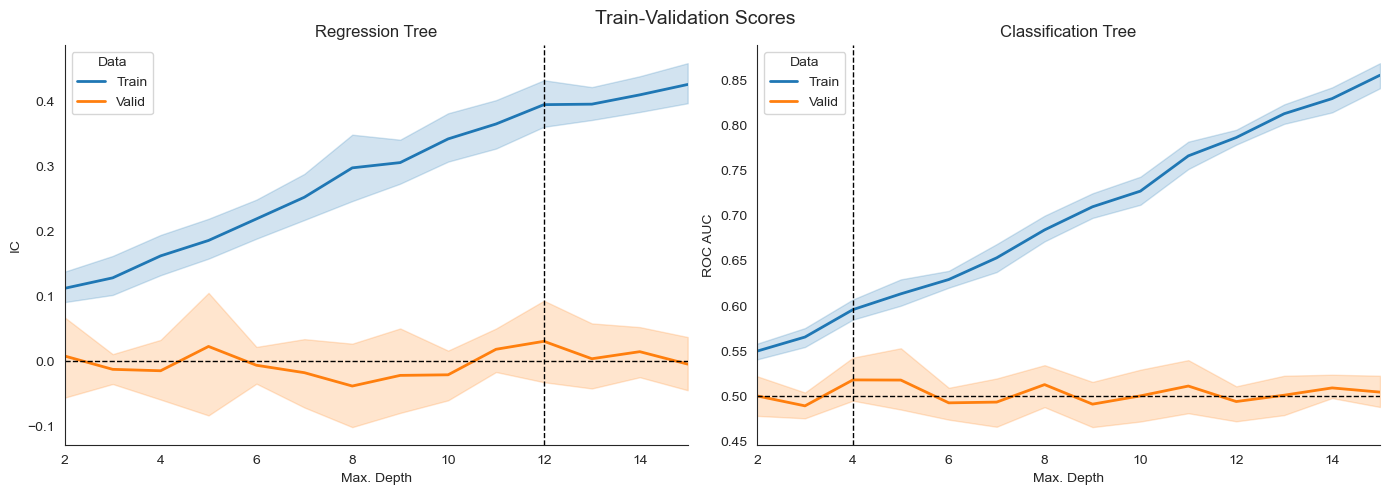

In [83]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.lineplot(data=reg_cv_data,
             x='Max. Depth', y='IC',
             hue='Data', ci=95,
             ax=axes[0], lw=2)

axes[0].set_title('Regression Tree')
axes[0].axvline(x=reg_valid_scores.mean().idxmax(), ls='--', c='k', lw=1)
axes[0].axhline(y=0, ls='--', c='k', lw=1)

sns.lineplot(data=clf_cv_data,
             x='Max. Depth', y='ROC AUC',
             hue='Data', ci=95,
             ax=axes[1], lw=2)

axes[1].set_title('Classification Tree')
axes[1].axvline(x=clf_valid_scores.mean().idxmax(), ls='--', c='k', lw=1)
axes[1].axhline(y=.5, ls='--', c='k', lw=1)
for ax in axes:
    ax.set_xlim(min(param_grid['max_depth']),
                max(param_grid['max_depth']))

fig.suptitle(f'Train-Validation Scores', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.91)

### Learning Curves for best models

A learning curve is a useful tool that displays how the validation and training score evolve as the number of training samples evolves.

The purpose of the learning curve is to find out whether and how much the model would benefit from using more data during training. It is also useful to diagnose whether the model's generalization error is more likely driven by bias or variance.

If, for example, both the validation score and the training score converge to a similarly low value despite an increasing training set size, the error is more likely due to bias, and additional training data is unlikely to help.

#### Classifier

In [84]:
sizes = np.arange(.1, 1.01, .1)

In [85]:
train_sizes, train_scores, valid_scores = learning_curve(gridsearch_clf.best_estimator_,
                                                         X,
                                                         y_binary,
                                                         train_sizes=sizes,
                                                         cv=cv,
                                                         scoring='roc_auc',
                                                         n_jobs=-1,
                                                         shuffle=True,
                                                         random_state=42)

In [86]:
clf_lc_data = pd.concat([
    pd.melt(pd.DataFrame(train_scores.T, columns=train_sizes),
            var_name='Train Size',
            value_name='ROC AUC').assign(Data='Train'),
    pd.melt(pd.DataFrame(valid_scores.T, columns=train_sizes),
            var_name='Train Size',
            value_name='ROC AUC').assign(Data='Valid')])
clf_lc_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Train Size  200 non-null    int64  
 1   ROC AUC     200 non-null    float64
 2   Data        200 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 6.2+ KB


#### Regression Tree

In [87]:
train_sizes, train_scores, valid_scores = learning_curve(gridsearch_reg.best_estimator_,
                                                         X, y,
                                                         train_sizes=sizes,
                                                         cv=cv,
                                                         scoring=ic,
                                                         n_jobs=-1,
                                                         shuffle=True,
                                                         random_state=42)

In [88]:
reg_lc_data = pd.concat([
    pd.melt(pd.DataFrame(train_scores.T,
                         columns=train_sizes),
            var_name='Train Size',
            value_name='IC').assign(Data='Train'),
    pd.melt(pd.DataFrame(valid_scores.T,
                         columns=train_sizes),
            var_name='Train Size',
            value_name='IC').assign(Data='Valid')])
reg_lc_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Train Size  200 non-null    int64  
 1   IC          200 non-null    float64
 2   Data        200 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 6.2+ KB


#### Compare Learning Curves

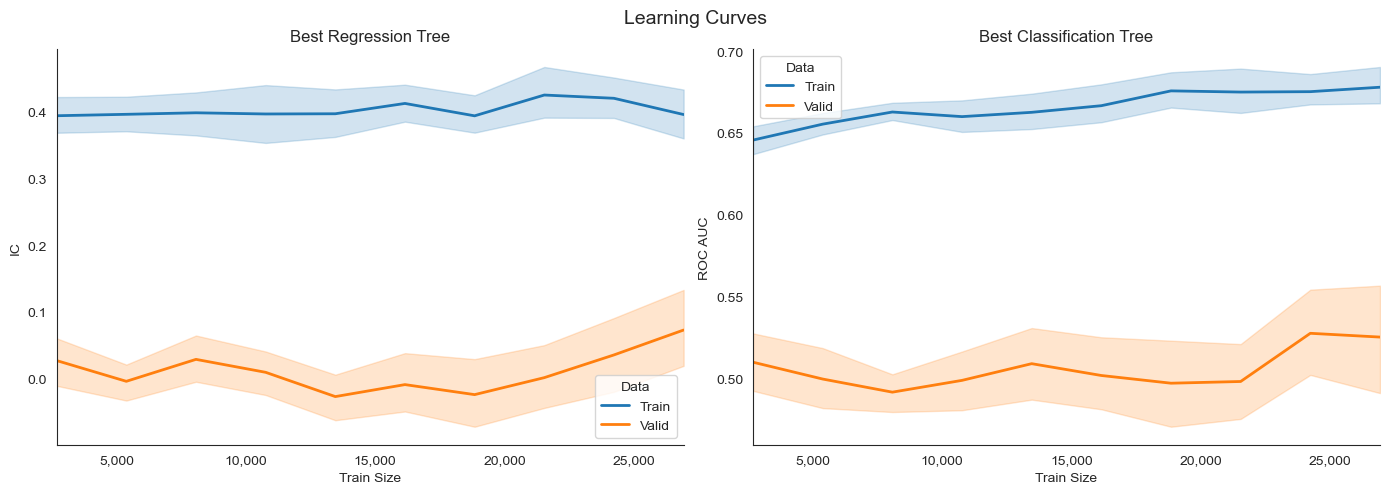

In [89]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
xmin, xmax = reg_lc_data['Train Size'].min(), reg_lc_data['Train Size'].max()

sns.lineplot(data=reg_lc_data,
             x='Train Size', y='IC',
             hue='Data', ci=95,  ax=axes[0], lw=2)
axes[0].set_title('Best Regression Tree')
axes[0].set_ylabel('IC')

axes[0].xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

sns.lineplot(data=clf_lc_data,
             x='Train Size',
             y='ROC AUC',
             hue='Data',
             ci=95,
             ax=axes[1],
             lw=2)
axes[1].set_title('Best Classification Tree')
axes[1].set_ylabel('ROC AUC')
axes[1].xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

for i in [0, 1]:
    axes[i].tick_params(axis='both', which='major', labelsize=10)
    axes[i].tick_params(axis='both', which='minor', labelsize=8)
    axes[i].set_xlim(xmin, xmax)

fig.suptitle('Learning Curves', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

### Feature Importance

Decision trees can not only be visualized to inspect the decision path for a given feature, but also provide a summary measure of the contribution of each feature to the model fit to the training data. 

The feature importance captures how much the splits produced by the feature helped to optimize the model's metric used to evaluate the split quality, which in our case is the Gini Impurity index. 

A feature's importance is computed as the (normalized) total reduction of this metric and takes into account the number of samples affected by a split. Hence, features used earlier in the tree where the nodes tend to contain more samples typically are considered of higher importance.

In [90]:
top_n = 15
labels = X.columns.str.replace('_', ' ').str.upper()
fi_clf = (pd.Series(gridsearch_clf.best_estimator_.feature_importances_, 
                    index=labels).sort_values(ascending=False).iloc[:top_n])
fi_reg = (pd.Series(gridsearch_reg.best_estimator_.feature_importances_, 
                    index=labels).sort_values(ascending=False).iloc[:top_n])

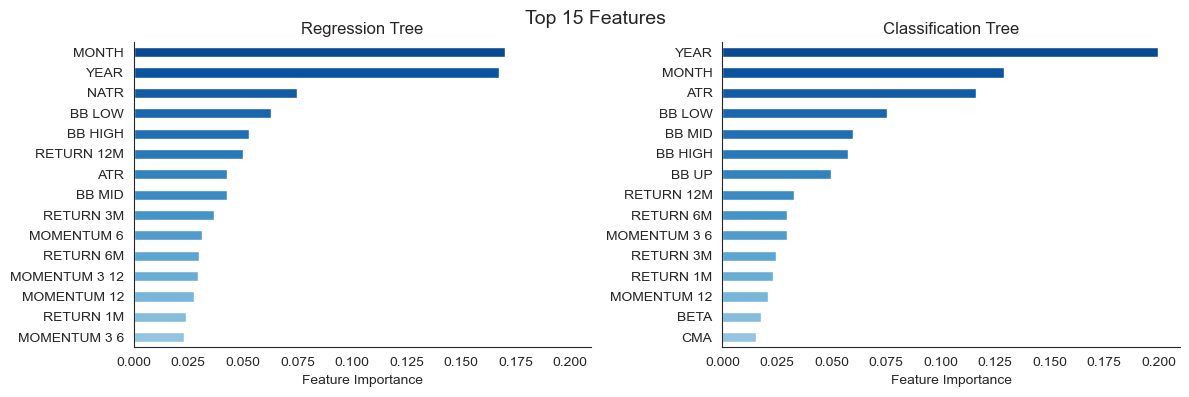

In [91]:
fig, axes= plt.subplots(ncols=2, figsize=(12,4), sharex=True)
color = cm.Blues(np.linspace(.4,.9, top_n))
fi_clf.sort_values().plot.barh(ax=axes[1], title='Classification Tree', color=color)
fi_reg.sort_values().plot.barh(ax=axes[0], title='Regression Tree', color=color)
axes[0].set_xlabel('Feature Importance')
axes[1].set_xlabel('Feature Importance')
fig.suptitle(f'Top {top_n} Features', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);